In [ ]:
# To access our dataset file
from google.colab import drive
drive.mount('/content/drive/')
dataset_path = '/content/drive/Shareddrives/AAX/Resources/dataset_Seminar4/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Importing modules
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

##Part 1: Data preparation & analysis
### 1.1. Describe the statistics behind the main parameters of the dataset. For that, make use of the plots that you consider.

First, we load the data in a Pandas Dataframe and visualize the structure.

In [ ]:
df = pd.read_csv(dataset_path + 'train_data.csv', sep=",")
df = df.apply(pd.to_numeric, errors='coerce') # Read numbers as numerics, not strings
print(df.head())

   LocationNumber   RSSI  TxLinkSpeed  RxLinkSpeed  MainAPConnect  \
0               2 -72.32       163.11       118.36              1   
1              32 -73.18       238.45       212.83              1   
2              20 -40.67       865.44       863.39              1   
3              10 -60.66       473.89       396.92              1   
4              29 -67.96       479.74       355.99              1   

   TxThroughput  AvgPingLatency  
0         13.51           51.79  
1          3.35           68.80  
2         17.62           50.79  
3         14.30           64.15  
4          4.81           73.81  


Then, to know how the values are distributed and what to expect, we check the mean and std of every column.

In [ ]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print(f"Mean: {df[col].mean()}")
    print(f"Std: {df[col].std()}")


Column: LocationNumber
Mean: 18.151160714285716
Std: 10.338002203241231

Column: RSSI
Mean: -62.364212202380955
Std: 9.442462796758843

Column: TxLinkSpeed
Mean: 491.2648735119048
Std: 240.86870024298344

Column: RxLinkSpeed
Mean: 460.95410684523813
Std: 251.60011532720264

Column: MainAPConnect
Mean: 0.9139583333333333
Std: 0.28042973944467414

Column: TxThroughput
Mean: 12.988919642857141
Std: 4.413972758193652

Column: AvgPingLatency
Mean: 54.77137172619047
Std: 8.735671766354027


After checking the data, we plot the histogram of the different columns and graphically see the distribution.

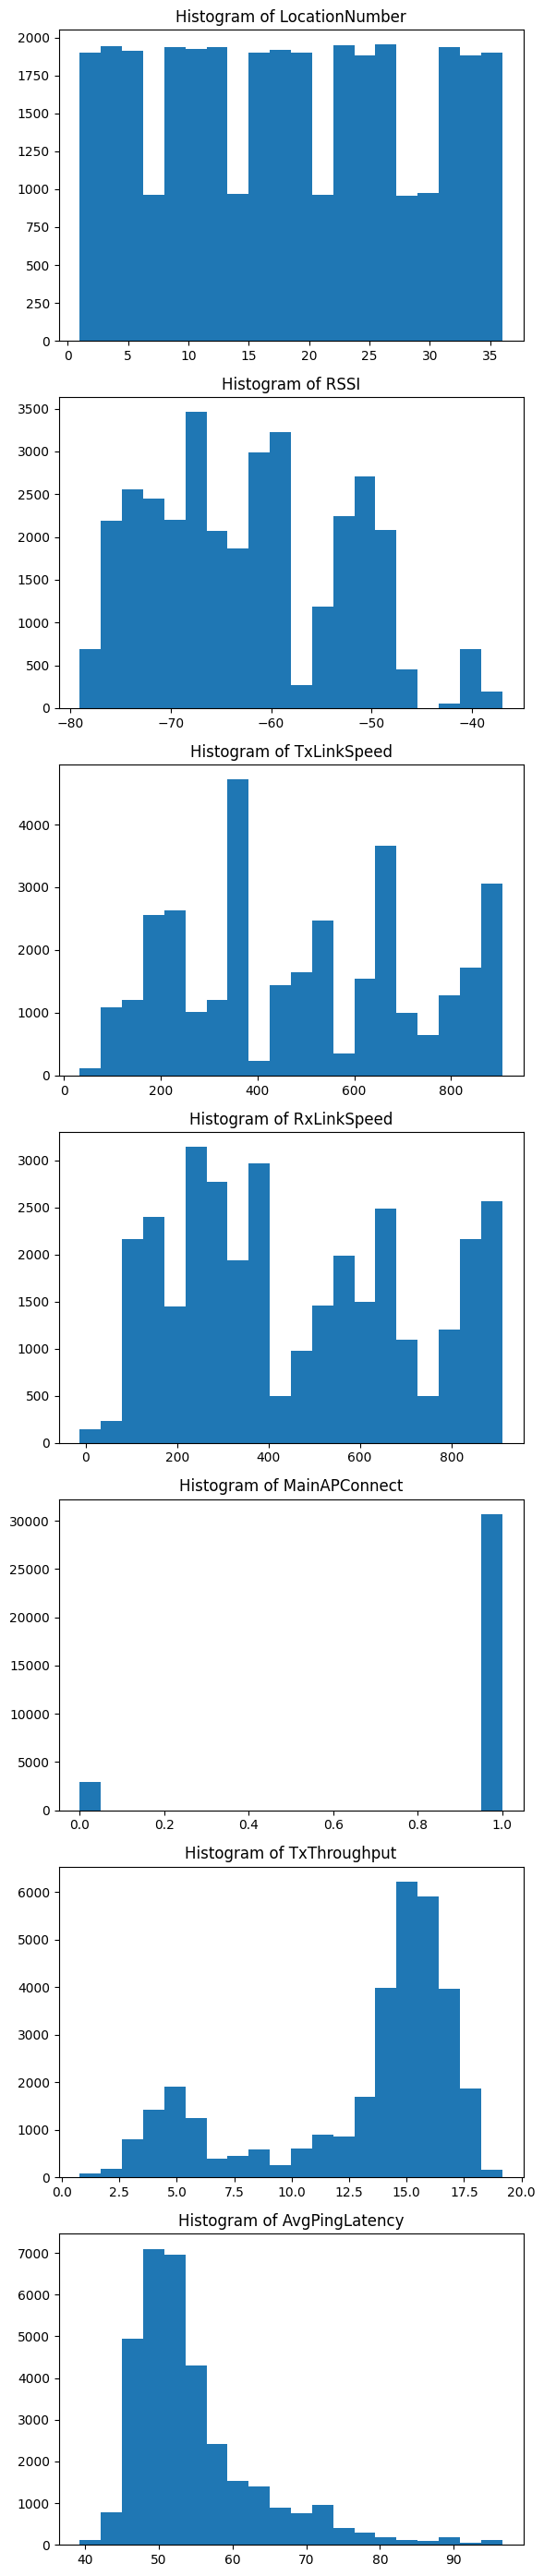

In [ ]:
# Number of columns
n = len(df.columns)

# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n))

# If only one subplot, axes is not a list — make it a list
if n == 1:
    axes = [axes]

# Plot each histogram
for ax, col in zip(axes, df.columns):
    ax.hist(df[col], bins=20)
    ax.set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()


LocationNumber and MainAPConnect represent an identifier and a boolean, respectively, so that should be taken into account when reading these values. The rest of the plots help us understand how the values are distributed in each column.

### 1.2. Perform a correlation analysis between the main features in the dataset and the performance metrics (throughput and delay).

Now, we plot the correlation matrix.

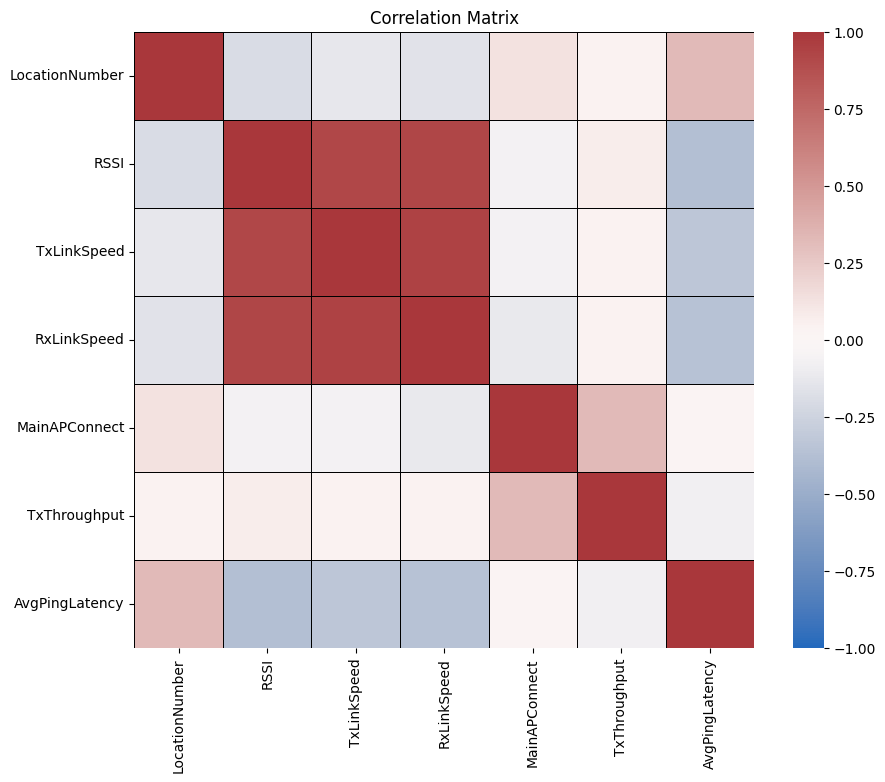

In [ ]:
plt.figure(figsize=(10,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmin=-1.0, vmax=1.0 , cmap= "vlag", center=0.0,
            linewidths=0.7, linecolor='black', cbar=True)
plt.title('Correlation Matrix')
plt.show()

The throughput does not seem to have a strong correlation with any of the features except for the MainAPConnect. This means that the throughput is usually bigger if the device is connected to the main AP and not an extender.

The average ping delay seems to be influenced by almost all features. Surprisingly, the location number seems to affect it, so there seems to be a geographical element that influences the latency. As for the rest, the lower the RSSI, transmission speed, and receiving speed, the bigger the latency, which is the common case. Surprisingly, being directly connected or through an extension does not impact the latency.

## Part 2: FNN-based performance predictor
### 2.1. Feature selection

For this model, we have to use every feature, as they affect either the throughput or the delay.

In [ ]:
features = ['LocationNumber', 'RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect']
train_features = df[features]

labels = ['TxThroughput', 'AvgPingLatency']
train_labels = df[labels]


### 2.1. Data preparation

Next, we create the train, val, and test splits and apply a power transformation (Yeo-Johnson) to the continuous features. It is important that we do not modify the MainAPConnect and the LocationNumber.

In [ ]:
X = train_features
y = train_labels

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_train, y_val, y_train = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('power_transform', PowerTransformer(), ['RSSI', 'TxLinkSpeed', 'RxLinkSpeed'])
    ],
    remainder='passthrough'  # Automatically pass through the non-transformed columns.
)

# Apply transformation
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)


# y has two columns: Throughput and Latency
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()


### 2.3. FNN architecture design

We are using PyTorch to create our own neural network.

First, we create new custom datasets from the train, test, and val data so we can transform the features and labels to tensors.

In [ ]:
# Dataset class
class WiFiDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = WiFiDataset(X_train_transformed, y_train)
test_dataset = WiFiDataset(X_test_transformed, y_test)
val_dataset = WiFiDataset(X_val_transformed, y_val)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # Use True to randomize the order of the data and get different results
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model class
class WiFiPredictor(nn.Module):
    def __init__(self, input_dim):
        super(WiFiPredictor, self).__init__()
        self.Activation = nn.Tanh()
        self.Linear1 = nn.Linear(input_dim, 64)
        self.Linear2 = nn.Linear(64, 128)
        self.Linear3 = nn.Linear(128, 64)
        self.Linear4 = nn.Linear(64, 2)

    def forward(self, x):
        l1 = self.Activation(self.Linear1(x))
        l2 = self.Activation(self.Linear2(l1))
        l3 = self.Activation(self.Linear3(l2))  # Residual connection removed
        l4 = self.Linear4(l3)
        return l4

# Initialize model, loss function (MSE), and optimizer
model = WiFiPredictor(input_dim=X_train_transformed.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

Then, we can create the neural network. We use the Hyperbolic Tangent (Tanh) function as the activation function.

tanh$(x)$ = $\frac{exp(x) - exp (-x)}{exp(x) + exp (-x)}$

Next, we define each hidden layer as a linear transformation plus a non-linear activation.
The input layer has 5 dimensions, the output layer has 2 dimensions, and the hidden layers between have 64, 128, and 64, respectively.

In [ ]:
# Model class
class WiFiPredictor(nn.Module):
    def __init__(self, input_dim):
        super(WiFiPredictor, self).__init__()
        self.Activation = nn.Tanh()
        self.Linear1 = nn.Linear(input_dim, 64)
        self.Linear2 = nn.Linear(64, 128)
        self.Linear3 = nn.Linear(128, 64)
        self.Linear4 = nn.Linear(64, 2)

    def forward(self, x):
        l1 = self.Activation(self.Linear1(x))
        l2 = self.Activation(self.Linear2(l1))
        l3 = self.Activation(self.Linear3(l2))  # Residual connection removed
        l4 = self.Linear4(l3)
        return l4

### 2.4 Train your FNN

We instantiate the model and use Mean Square Error as our loss function and Adam as our optimizer. Then, we train the model for 100 epochs and evaluate using the validation split each epoch. Finally, we plot the training and validation loss over epochs.

Epoch 1, Train Loss: 652.4492, Val Loss: 207.0934
Epoch 2, Train Loss: 102.0253, Val Loss: 53.6281
Epoch 3, Train Loss: 49.8714, Val Loss: 47.4596
Epoch 4, Train Loss: 48.2359, Val Loss: 47.4312
Epoch 5, Train Loss: 48.2165, Val Loss: 47.4443
Epoch 6, Train Loss: 48.2250, Val Loss: 46.4072
Epoch 7, Train Loss: 40.8262, Val Loss: 35.9738
Epoch 8, Train Loss: 35.2925, Val Loss: 34.3804
Epoch 9, Train Loss: 34.2868, Val Loss: 34.0323
Epoch 10, Train Loss: 34.2248, Val Loss: 33.8082
Epoch 11, Train Loss: 33.9569, Val Loss: 33.6020
Epoch 12, Train Loss: 33.8859, Val Loss: 33.5273
Epoch 13, Train Loss: 33.8750, Val Loss: 33.5138
Epoch 14, Train Loss: 33.7769, Val Loss: 33.4429
Epoch 15, Train Loss: 33.6864, Val Loss: 33.3451
Epoch 16, Train Loss: 33.6358, Val Loss: 33.3034
Epoch 17, Train Loss: 33.5742, Val Loss: 33.2486
Epoch 18, Train Loss: 33.4890, Val Loss: 33.2129
Epoch 19, Train Loss: 33.4202, Val Loss: 33.1410
Epoch 20, Train Loss: 33.3364, Val Loss: 33.0280
Epoch 21, Train Loss: 33.2

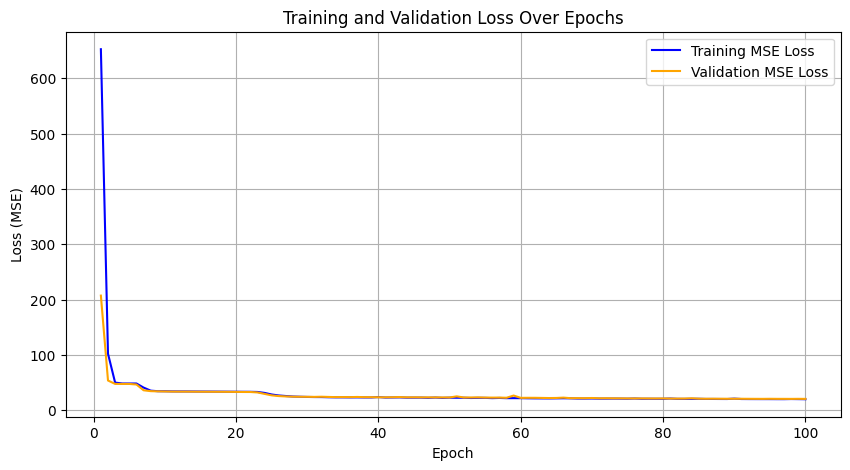

In [ ]:
# Initialize model, loss function (MSE), and optimizer
model = WiFiPredictor(input_dim=X_train_transformed.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Training loop with validation tracking
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # Disables gradient for validation
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            running_val_loss += val_loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training MSE Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation MSE Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

We end the training phase with a validation loss of 20.3972 for this execution, which is not quite good. Both in the traces and in the plot, we can see how the training and validation loss align, so there is no overfitting or underfitting.

### 2.5. Evaluate your FNN

Finally, we evaluate our model using the test data.

In [ ]:
from sklearn.metrics import r2_score

# Predictions from your model
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_preds.append(outputs.numpy())
        all_targets.append(targets.numpy())

# Flatten and compute R²
preds = np.vstack(all_preds)
targets = np.vstack(all_targets)
print("R² Score:", r2_score(targets, preds))


model.eval()
total_mae = 0.0
total_mse = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total_mae += nn.L1Loss()(outputs, targets).item()
        total_mse += nn.MSELoss()(outputs, targets).item()

avg_mae = total_mae / len(test_loader)
avg_mse = total_mse / len(test_loader)

print(f"Test MAE: {avg_mae:.4f}")
print(f"Test MSE: {avg_mse:.4f}")


R² Score: 0.48270726203918457
Test MAE: 3.2425
Test MSE: 19.9586


When evaluating the model with the test data, we end up with a similar MSE as when doing the validation. Our R$ ^2$ score is quite low, ranging from 0.4 to 0.5 depending on the randomness. We have confirmed before that there is no overfitting or underfitting by comparing the training and validation loss. The problem with the lack of accuracy could either be because of the dataset quality or that the model type and hyperparameters are poorly chosen for the task we wanted to accomplish. We have tried using different hidden layer configurations, changing the optimization function and the activation function, but we have not managed to achieve a better result.